<a href="https://colab.research.google.com/github/anushil-dev/Fake_News_Detection/blob/main/final_fnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import sklearn
import itertools
import numpy as np
import seaborn as sb
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [45]:
# Load all three datasets
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')
df3 = pd.read_csv('valid.csv')

# Combine them into one big table
train_df = pd.concat([df1, df2, df3], ignore_index=True)

# Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)

print(f"New SUPER dataset size: {train_df.shape}")
train_df.head()

New SUPER dataset size: (15362, 2)


,Statement,Label
0,"The Medicare proposal by Rep. Paul Ryan, R-Wis...",False
1,Says she stood up to Gov. Scott Walker on tax ...,TRUE
2,Says Ted Cruz just flip-flopped about the pres...,False
3,Appalachian Power Company is making record pro...,False
4,Despite raising taxes on the wealthy and hikin...,True


In [46]:
# 1. Convert "TRUE"/"FALSE" to 1/0
# This mapping handles variations like 'True', 'true', 'TRUE'
label_mapping = {
    'TRUE': 1,
    'True': 1,
    'true': 1,
    'FALSE': 0,
    'False': 0,
    'false': 0
}

# Apply the mapping
train_df['Label'] = train_df['Label'].map(label_mapping)

# 2. Drop any rows that didn't convert correctly (removes garbage data)
train_df = train_df.dropna(subset=['Label'])

# 3. Make sure the Label column is integers (whole numbers)
train_df['Label'] = train_df['Label'].astype(int)

print("Labels cleaned successfully!")
print(train_df.head())

Labels cleaned successfully!
                                            Statement  Label
1   Says she stood up to Gov. Scott Walker on tax ...      1
6   Georgia is nearly 50 percent Democratic and (t...      1
13  Says Rick Perry supported a guest worker progr...      1
14  The Health Care Compact bill would end Medicar...      0
19  There are over 100 pipelines between the Unite...      0


In [47]:
train_df.head(15)

,Statement,Label
1,Says she stood up to Gov. Scott Walker on tax ...,1
6,Georgia is nearly 50 percent Democratic and (t...,1
13,Says Rick Perry supported a guest worker progr...,1
14,The Health Care Compact bill would end Medicar...,0
19,There are over 100 pipelines between the Unite...,0
20,The American murder rate is 50 times that of a...,0
37,The USAFreedom Act undercuts privacy becauseth...,0
42,Weve seen six months of positive job growth by...,1
43,The presidents party always gets shellacked in...,1
54,We have spent $350 million to deal with sea-le...,0


In [48]:
train_df = train_df.drop("author", axis = 1)
train_df = train_df.drop("title", axis = 1)
train_df = train_df.drop("id", axis = 1)

KeyError: "['author'] not found in axis"

In [49]:
train_df.shape

(2568, 2)

In [50]:
train_df.head(15)

,Statement,Label
1,Says she stood up to Gov. Scott Walker on tax ...,1
6,Georgia is nearly 50 percent Democratic and (t...,1
13,Says Rick Perry supported a guest worker progr...,1
14,The Health Care Compact bill would end Medicar...,0
19,There are over 100 pipelines between the Unite...,0
20,The American murder rate is 50 times that of a...,0
37,The USAFreedom Act undercuts privacy becauseth...,0
42,Weve seen six months of positive job growth by...,1
43,The presidents party always gets shellacked in...,1
54,We have spent $350 million to deal with sea-le...,0


In [52]:
print(train_df.columns)

Index(['Statement', 'Label'], dtype='object')


/tmp/ipython-input-1539356529.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  return sb.countplot(x='Label', data=dataFile, palette='hls')


<Axes: xlabel='Label', ylabel='count'>

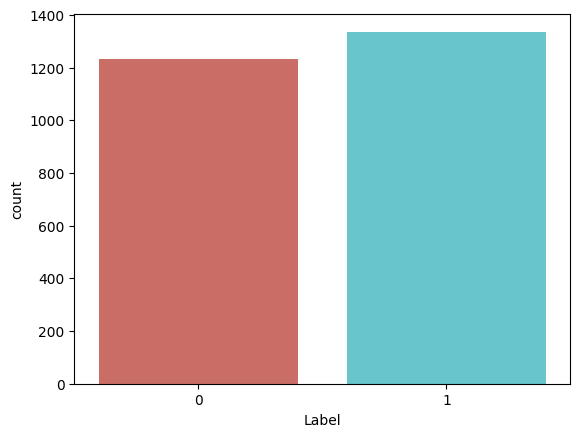

In [53]:
def create_distribution(dataFile):
    return sb.countplot(x='Label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_df)

In [54]:
def data_qualityCheck():
    print("Checking data qualitites...")
    train_df.isnull().sum()
    train_df.info()
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
Index: 2568 entries, 1 to 15351
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  2568 non-null   object
 1   Label      2568 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.2+ KB
check finished.


In [55]:
train_df = train_df.dropna()

In [56]:
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
Index: 2568 entries, 1 to 15351
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  2568 non-null   object
 1   Label      2568 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.2+ KB
check finished.


In [57]:
train_df.shape

(2568, 2)

In [15]:
train_df.head(10)

,Statement,Label
3,"The Senate-passed health care bill ""is identic...",1
4,Says that in 2009 ExxonMobil paid no federal i...,0
22,Says Texas is dead last in support for mental ...,1
24,"In the last 29 months, our economy has produce...",1
28,Most polls show foreign nations have lower reg...,0
62,"McCain and Bush are millionaires who are ""for ...",1
65,"The last quarter, it was just announced, our g...",0
66,"The U.S. ""only ranks 25th worldwide on defense...",0
69,Obama's Ten Point Plan to 'Change' the Second ...,0
70,Ilana Shafran Mandels stake in Forest City Ent...,1


In [16]:
train_df.reset_index(drop= True,inplace=True)

In [17]:
train_df.head(10)

,Statement,Label
0,"The Senate-passed health care bill ""is identic...",1
1,Says that in 2009 ExxonMobil paid no federal i...,0
2,Says Texas is dead last in support for mental ...,1
3,"In the last 29 months, our economy has produce...",1
4,Most polls show foreign nations have lower reg...,0
5,"McCain and Bush are millionaires who are ""for ...",1
6,"The last quarter, it was just announced, our g...",0
7,"The U.S. ""only ranks 25th worldwide on defense...",0
8,Obama's Ten Point Plan to 'Change' the Second ...,0
9,Ilana Shafran Mandels stake in Forest City Ent...,1


In [18]:
Label_train = train_df.Label

In [19]:
Label_train.head(10)

,Label
0,1
1,0
2,1
3,1
4,0
5,1
6,0
7,0
8,0
9,1


In [20]:
train_df = train_df.drop("Label", axis = 1)

In [21]:
train_df.head(10)

,Statement
0,"The Senate-passed health care bill ""is identic..."
1,Says that in 2009 ExxonMobil paid no federal i...
2,Says Texas is dead last in support for mental ...
3,"In the last 29 months, our economy has produce..."
4,Most polls show foreign nations have lower reg...
5,"McCain and Bush are millionaires who are ""for ..."
6,"The last quarter, it was just announced, our g..."
7,"The U.S. ""only ranks 25th worldwide on defense..."
8,Obama's Ten Point Plan to 'Change' the Second ...
9,Ilana Shafran Mandels stake in Forest City Ent...


In [22]:
train_df['Statement'][2188]

'When my grandfather came to this country back in 1925, there were no government benefits.'

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [25]:
stpwrds

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
import nltk
nltk.download('punkt')
nltk.download('wordnet') # Re-download wordnet too, just in case

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
for x in range(len(train_df)) :
    corpus = []
    review = train_df['Statement'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = review.split()
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    train_df['Statement'][x] = review

/tmp/ipython-input-2708645758.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['Statement'][x] = review


In [29]:
train_df['Statement'][2182]

'say michelle obama mandate weighing child day care'

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df['Statement'], Label_train, test_size=0.3, random_state=1)

In [31]:
X_train

,Statement
45,michelle nunn praised occupy movement
1483,say federal government supporting study hawaii...
48,romney left massachusetts million debt big gov...
669,sen mcconnell offered fully paid twomonth exte...
1400,say democratic party created planned parenthood
...,...
960,say state sen paul sarlo said february njtv ta...
905,affordable care act say age need eligible canc...
1096,say charlie crist stood africanamerican prison...
235,energy nominee steven chu called coal worst ni...


In [32]:
X_train.shape

(1797,)

In [33]:
Y_train

,Label
45,0
1483,1
48,0
669,1
1400,0
...,...
960,1
905,0
1096,1
235,1


In [34]:
tfidf_v = TfidfVectorizer()
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [35]:
tfidf_X_train.shape

(1797, 3501)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(tfidf_X_train, Y_train)

LogisticRegression()

Accuracy: 79.77%
Confusion matrix, without normalization


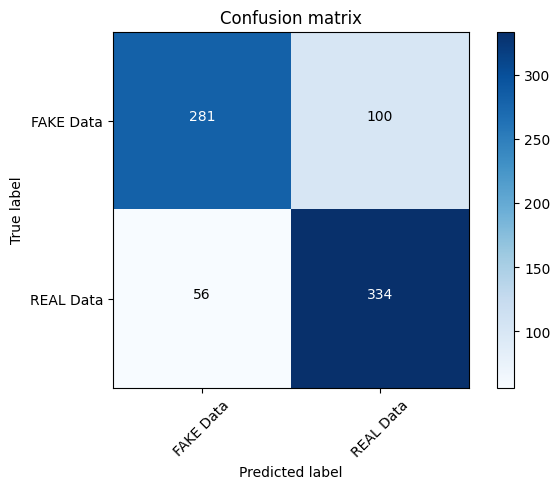

In [38]:
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

In [39]:
pickle.dump(classifier,open('./model.pkl', 'wb'))

In [40]:
# load the model from disk
loaded_model = pickle.load(open('./model.pkl', 'rb'))

In [41]:
def fake_news_det(news):
    review = news
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = review.split()
    corpus = []
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    input_data = [' '.join(corpus)]
    vectorized_input_data = tfidf_v.transform(input_data)
    prediction = loaded_model.predict(vectorized_input_data)
    if prediction[0] == 0:
        print("Prediction of the News :  Looking Real⚠ News📰 ")
    else:
        print("Prediction of the News : Looking Fake News📰 ")

In [43]:
news_to_test = "PM Modi proposes new initiatives on health, skills at G-20 summit"
fake_news_det(news_to_test)

Prediction of the News : Looking Fake News📰 
